In [1]:
import numpy as np
import pandas as pd
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import WhitespaceTokenizer

from gensim.models import Word2Vec
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.model_selection import train_test_split

nltk.download('stopwords')
nltk.download('wordnet')
import re
import matplotlib.pyplot as plt

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/habkaffee/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/habkaffee/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
# dataset = pd.read_csv('data/DATASET.csv')
# dataset

# Preprocessing

In [3]:
exclude_symbols = u''.join(['№', '«', 'ђ', '°', '±', '‚', 'ћ', '‰', '…', '»', 'ѓ', 'µ', '·', 'ґ', 'њ', 'ї', 'џ', 'є', '‹',
                            '‡', '†', '¶', 'ќ', '€', '“', 'ў', '§', '„', '”', '\ufeff', '’', 'љ', '›', '•', '—', '‘', 
                            '\x7f', '\xad', '¤', '\xa0', '\u200b', '–']) + string.punctuation
regex_symb = re.compile('[%s]' % re.escape(exclude_symbols))

In [4]:
stop_words = stopwords.words('english')
pattern = r'\b(?:' + '|'.join(stop_words) + r')\b'
stop_words[:10]

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]

In [5]:
tokenizer = WhitespaceTokenizer()
lemmatizer = WordNetLemmatizer()

In [6]:
# def lemmatize_sentence(sentence):
#     if isinstance(sentence, str):
#       sentence = [lemmatizer.lemmatize(word) for word in tokenizer.tokenize(sentence)]
#     return sentence

In [7]:
dataset = pd.read_csv('data/DATASET.csv')
dataset['Review'] = dataset['Review'].str.lower()
dataset = dataset.loc[dataset['Review'].apply(lambda x: isinstance(x, str) and x.isascii())]
dataset['label'] = dataset['label'].str.replace('POSITIVE', '1').replace('NEGATIVE', '0')
dataset['Review'] = dataset['Review'].str.replace(pattern, '', regex=True)
dataset['Review'] = dataset['Review'].str.replace(f'[{string.punctuation}]+', ' ', regex=True)
dataset['Review'] = dataset['Review'].str.replace(r'\s+', ' ', regex=True)
dataset['Review'] = dataset['Review'].str.replace(f'[0-9]+', '', regex=True)

dataset['Review'] = dataset['Review'].apply(lambda sentence : tokenizer.tokenize(sentence))
dataset['Review'] = dataset['Review'].apply(lambda sentence : [lemmatizer.lemmatize(word, pos='n') for word in sentence])
dataset['Review'] = dataset['Review'].apply(lambda sentence : [lemmatizer.lemmatize(word, pos='v') for word in sentence])
dataset['Review'] = dataset['Review'].apply(lambda sentence : [lemmatizer.lemmatize(word, pos='a') for word in sentence])
dataset['Review'] = dataset['Review'].apply(lambda sentence : [lemmatizer.lemmatize(word, pos='r') for word in sentence])
# dataset['Review'] = dataset['Review'].apply(lambda sentence : ' '.join(sentence))
dataset

,Review,label
0,"[great, music, service, audio, high, quality, ...",1
1,"[please, ignore, previous, negative, rat, app,...",1
2,"[pop, get, best, spotify, experience, android,...",0
3,"[really, buggy, terrible, use, recently]",0
4,"[dear, spotify, get, song, put, playlist, shuf...",0
...,...,...
52697,"[yes, best]",1
52698,"[spotify, heart, feb, heart, music, lyric, lan...",1
52699,"[try, open, app, wont, open, restart, phone, i...",1
52700,[good],1


In [8]:
X, Y = dataset['Review'], dataset['label']

In [9]:
X.head()

0    [great, music, service, audio, high, quality, ...
1    [please, ignore, previous, negative, rat, app,...
2    [pop, get, best, spotify, experience, android,...
3             [really, buggy, terrible, use, recently]
4    [dear, spotify, get, song, put, playlist, shuf...
Name: Review, dtype: object

In [10]:
Y.head()

0    1
1    1
2    0
3    0
4    0
Name: label, dtype: object

In [11]:
all_words = set()
for data in X:
    all_words.update(data)
pd.DataFrame(all_words).T

,0,1,2,3,4,5,6,7,8,9,...,15392,15393,15394,15395,15396,15397,15398,15399,15400,15401
0,intricate,kroger,wifi,overarch,countless,hijack,onlynapp,abnormally,wabt,poner,...,rreallly,housework,mont,adios,useage,fork,sth,shirt,tittle,cooperative


In [12]:
len(all_words)

15402

In [13]:
vectorizer = Word2Vec(X, vector_size=100, workers=4, min_count=3)
seed = 42

In [14]:
vectorizer.wv['app']

array([ 0.3130541 ,  0.35812715,  0.5448667 ,  0.31108427, -0.8245288 ,
       -0.714784  , -0.6085036 ,  1.1736956 , -0.7361906 ,  0.26291087,
        0.46788907,  0.08994526, -0.33480304,  1.4417411 , -0.01840737,
       -0.57990134, -0.04277718,  0.09661716,  0.20448096,  0.7293754 ,
        0.19033672, -0.31082043,  0.10125582,  0.06876709,  0.59068865,
        0.47169048,  0.2969946 ,  0.07794444, -0.54570556,  0.51662076,
       -0.09132324, -0.5672987 ,  0.7908545 , -0.5944888 ,  0.16975291,
        0.5289563 ,  0.64134973, -0.53278804,  0.9544218 , -0.1541316 ,
       -1.1372023 ,  0.60789424,  0.3076321 , -0.00434916,  0.21096241,
       -0.15450718,  0.28618908,  0.78777206,  1.3554043 , -0.4664213 ,
        0.5647667 ,  1.2442716 , -0.20088674, -0.7305257 ,  1.8286911 ,
       -0.66403985,  0.34636548,  0.16501369,  0.05450298, -0.17960139,
       -0.13708647,  0.76087546, -0.02828667, -0.6221647 , -0.2210206 ,
        0.05562142,  0.7218948 ,  0.80009365, -0.33491957, -0.74

In [15]:
def sentence_to_vector(sentence, model, vector_size):
    # Filter out words that are not in the model vocabulary
    words = [word for word in sentence if word in model.wv]
    if not words:
        return np.zeros(vector_size)  # Return a zero vector if no words in the model
    return np.mean([model.wv[word] for word in words], axis=0)

X_vectors = np.array([sentence_to_vector(sentence, vectorizer, 100) for sentence in X])

In [16]:
X_train, X_test, Y_train, Y_test = train_test_split(X_vectors, Y, test_size=0.25, random_state=seed)

# ML algs

In [17]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB

from sklearn.metrics import precision_score, accuracy_score, recall_score, f1_score

from sklearn.model_selection import GridSearchCV

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [18]:
def get_gridsearch_for_model(model, parameters : dict) -> GridSearchCV:
    model_grid = GridSearchCV(
        estimator=model,
        param_grid=parameters,
        scoring=['f1_micro', 'accuracy', 'recall_macro'],
        refit='f1_micro',
        cv=5,
        verbose=2,
        error_score=0
    )
    return model_grid

def print_grid_search_info(model):
    print(f'Best estimator -> {model.best_estimator_}\n\
Best Score -> {model.best_score_}\n\
Best Parameters -> {model.best_params_}\n\
Best index -> {model.best_index_}')


def print_metrics(y_test, y_pred):
    print(f'f1_micro = {f1_score(y_test, y_pred, average="micro")}\nrecall_score = {recall_score(y_test, y_pred, average="macro")}\nprecision_score = {precision_score(y_test, y_pred, average="macro")}')


def display_conf_matrix(y_true, y_pred, Y):
    conf_matrix = confusion_matrix(y_true, y_pred)
    cm_display = ConfusionMatrixDisplay(conf_matrix, display_labels=Y.unique())
    cm_display.plot()
    plt.show()

In [19]:
parameters_logreg = {
    'penalty': ['l1', 'l2'],
    'C': [0.01, 0.1, 0.5, 1.0, 10.0],
    'solver': ['lbfgs', 'liblinear'],
    'max_iter': [100, 500, 1000]
}

grid_log = get_gridsearch_for_model(LogisticRegression(), parameters_logreg)

grid_log.fit(X_train, Y_train)
print_grid_search_info(grid_log)

Fitting 5 folds for each of 60 candidates, totalling 300 fits
[CV] END .....C=0.01, max_iter=100, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END .....C=0.01, max_iter=100, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END .....C=0.01, max_iter=100, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END .....C=0.01, max_iter=100, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END .....C=0.01, max_iter=100, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END .C=0.01, max_iter=100, penalty=l1, solver=liblinear; total time=   0.4s
[CV] END .C=0.01, max_iter=100, penalty=l1, solver=liblinear; total time=   0.4s
[CV] END .C=0.01, max_iter=100, penalty=l1, solver=liblinear; total time=   0.3s
[CV] END .C=0.01, max_iter=100, penalty=l1, solver=liblinear; total time=   0.3s
[CV] END .C=0.01, max_iter=100, penalty=l1, solver=liblinear; total time=   0.4s
[CV] END .....C=0.01, max_iter=100, penalty=l2, solver=lbfgs; total time=   0.3s
[CV] END .....C=0.01, max_iter=100, penalty=l2,

/home/habkaffee/programming/nlp/nlp_classification/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END ......C=1.0, max_iter=100, penalty=l2, solver=lbfgs; total time=   0.8s
[CV] END ......C=1.0, max_iter=100, penalty=l2, solver=lbfgs; total time=   1.1s


/home/habkaffee/programming/nlp/nlp_classification/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END ......C=1.0, max_iter=100, penalty=l2, solver=lbfgs; total time=   0.9s
[CV] END ......C=1.0, max_iter=100, penalty=l2, solver=lbfgs; total time=   0.9s


/home/habkaffee/programming/nlp/nlp_classification/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END ......C=1.0, max_iter=100, penalty=l2, solver=lbfgs; total time=   0.9s
[CV] END ..C=1.0, max_iter=100, penalty=l2, solver=liblinear; total time=   1.6s
[CV] END ..C=1.0, max_iter=100, penalty=l2, solver=liblinear; total time=   1.6s
[CV] END ..C=1.0, max_iter=100, penalty=l2, solver=liblinear; total time=   1.5s
[CV] END ..C=1.0, max_iter=100, penalty=l2, solver=liblinear; total time=   1.6s
[CV] END ..C=1.0, max_iter=100, penalty=l2, solver=liblinear; total time=   1.5s
[CV] END ......C=1.0, max_iter=500, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END ......C=1.0, max_iter=500, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END ......C=1.0, max_iter=500, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END ......C=1.0, max_iter=500, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END ......C=1.0, max_iter=500, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END ..C=1.0, max_iter=500, penalty=l1, solver=liblinear; total time=  12.5s
[CV] END ..C=1.0, max_iter=5

/home/habkaffee/programming/nlp/nlp_classification/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END .....C=10.0, max_iter=100, penalty=l2, solver=lbfgs; total time=   1.5s


/home/habkaffee/programming/nlp/nlp_classification/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END .....C=10.0, max_iter=100, penalty=l2, solver=lbfgs; total time=   1.2s


/home/habkaffee/programming/nlp/nlp_classification/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END .....C=10.0, max_iter=100, penalty=l2, solver=lbfgs; total time=   1.2s


/home/habkaffee/programming/nlp/nlp_classification/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END .....C=10.0, max_iter=100, penalty=l2, solver=lbfgs; total time=   1.6s


/home/habkaffee/programming/nlp/nlp_classification/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END .....C=10.0, max_iter=100, penalty=l2, solver=lbfgs; total time=   1.6s
[CV] END .C=10.0, max_iter=100, penalty=l2, solver=liblinear; total time=   3.8s
[CV] END .C=10.0, max_iter=100, penalty=l2, solver=liblinear; total time=   3.6s
[CV] END .C=10.0, max_iter=100, penalty=l2, solver=liblinear; total time=   3.5s
[CV] END .C=10.0, max_iter=100, penalty=l2, solver=liblinear; total time=   3.0s
[CV] END .C=10.0, max_iter=100, penalty=l2, solver=liblinear; total time=   3.5s
[CV] END .....C=10.0, max_iter=500, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END .....C=10.0, max_iter=500, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END .....C=10.0, max_iter=500, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END .....C=10.0, max_iter=500, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END .....C=10.0, max_iter=500, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END .C=10.0, max_iter=500, penalty=l1, solver=liblinear; total time=  41.9s
[CV] END .C=10.0, max_iter=5

/home/habkaffee/programming/nlp/nlp_classification/.venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
75 fits failed out of a total of 300.
The score on these train-test partitions for these parameters will be set to 0.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
75 fits failed with the following error:
Traceback (most recent call last):
  File "/home/habkaffee/programming/nlp/nlp_classification/.venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/habkaffee/programming/nlp/nlp_classification/.venv/lib/python3.12/site-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

Best estimator -> LogisticRegression(C=10.0, solver='liblinear')
Best Score -> 0.8617753120665741
Best Parameters -> {'C': 10.0, 'max_iter': 100, 'penalty': 'l2', 'solver': 'liblinear'}
Best index -> 51


In [20]:
Y_pred_logreg = grid_log.predict(X_test)
print_metrics(Y_test, Y_pred_logreg)
# save_model('./models/log_reg_trash.pkl', grid_log)

f1_micro = 0.8595323292002995
recall_score = 0.8529393426560969
precision_score = 0.8591312171215727


In [21]:
parameters_linSVC = {
    'penalty': ['l1', 'l2'],
    'loss': ['hinge', 'squared_hinge'],
    'C': np.linspace(0.001, 0.1, 7),
    'max_iter': [1000, 3000, 5000],
    'dual':[True]
}

grid_linearSVC = get_gridsearch_for_model(LinearSVC(), parameters_linSVC)

grid_linearSVC.fit(X_train, Y_train)
print_grid_search_info(grid_linearSVC)

Fitting 5 folds for each of 84 candidates, totalling 420 fits
[CV] END C=0.001, dual=True, loss=hinge, max_iter=1000, penalty=l1; total time=   0.0s
[CV] END C=0.001, dual=True, loss=hinge, max_iter=1000, penalty=l1; total time=   0.0s
[CV] END C=0.001, dual=True, loss=hinge, max_iter=1000, penalty=l1; total time=   0.0s
[CV] END C=0.001, dual=True, loss=hinge, max_iter=1000, penalty=l1; total time=   0.0s
[CV] END C=0.001, dual=True, loss=hinge, max_iter=1000, penalty=l1; total time=   0.0s
[CV] END C=0.001, dual=True, loss=hinge, max_iter=1000, penalty=l2; total time=   0.2s
[CV] END C=0.001, dual=True, loss=hinge, max_iter=1000, penalty=l2; total time=   0.2s
[CV] END C=0.001, dual=True, loss=hinge, max_iter=1000, penalty=l2; total time=   0.2s
[CV] END C=0.001, dual=True, loss=hinge, max_iter=1000, penalty=l2; total time=   0.2s
[CV] END C=0.001, dual=True, loss=hinge, max_iter=1000, penalty=l2; total time=   0.3s
[CV] END C=0.001, dual=True, loss=hinge, max_iter=3000, penalty=l1; 

/home/habkaffee/programming/nlp/nlp_classification/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=0.0175, dual=True, loss=hinge, max_iter=1000, penalty=l2; total time=   0.3s
[CV] END C=0.0175, dual=True, loss=hinge, max_iter=1000, penalty=l2; total time=   0.3s
[CV] END C=0.0175, dual=True, loss=hinge, max_iter=1000, penalty=l2; total time=   0.3s
[CV] END C=0.0175, dual=True, loss=hinge, max_iter=1000, penalty=l2; total time=   0.3s
[CV] END C=0.0175, dual=True, loss=hinge, max_iter=1000, penalty=l2; total time=   0.3s
[CV] END C=0.0175, dual=True, loss=hinge, max_iter=3000, penalty=l1; total time=   0.0s
[CV] END C=0.0175, dual=True, loss=hinge, max_iter=3000, penalty=l1; total time=   0.0s
[CV] END C=0.0175, dual=True, loss=hinge, max_iter=3000, penalty=l1; total time=   0.0s
[CV] END C=0.0175, dual=True, loss=hinge, max_iter=3000, penalty=l1; total time=   0.0s
[CV] END C=0.0175, dual=True, loss=hinge, max_iter=3000, penalty=l1; total time=   0.0s
[CV] END C=0.0175, dual=True, loss=hinge, max_iter=3000, penalty=l2; total time=   0.3s
[CV] END C=0.0175, dual=True, lo

/home/habkaffee/programming/nlp/nlp_classification/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=0.034, dual=True, loss=hinge, max_iter=1000, penalty=l2; total time=   0.2s


/home/habkaffee/programming/nlp/nlp_classification/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=0.034, dual=True, loss=hinge, max_iter=1000, penalty=l2; total time=   0.3s
[CV] END C=0.034, dual=True, loss=hinge, max_iter=1000, penalty=l2; total time=   0.4s


/home/habkaffee/programming/nlp/nlp_classification/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=0.034, dual=True, loss=hinge, max_iter=1000, penalty=l2; total time=   0.2s


/home/habkaffee/programming/nlp/nlp_classification/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=0.034, dual=True, loss=hinge, max_iter=1000, penalty=l2; total time=   0.3s
[CV] END C=0.034, dual=True, loss=hinge, max_iter=3000, penalty=l1; total time=   0.0s
[CV] END C=0.034, dual=True, loss=hinge, max_iter=3000, penalty=l1; total time=   0.0s
[CV] END C=0.034, dual=True, loss=hinge, max_iter=3000, penalty=l1; total time=   0.0s
[CV] END C=0.034, dual=True, loss=hinge, max_iter=3000, penalty=l1; total time=   0.0s
[CV] END C=0.034, dual=True, loss=hinge, max_iter=3000, penalty=l1; total time=   0.0s
[CV] END C=0.034, dual=True, loss=hinge, max_iter=3000, penalty=l2; total time=   0.4s
[CV] END C=0.034, dual=True, loss=hinge, max_iter=3000, penalty=l2; total time=   0.4s
[CV] END C=0.034, dual=True, loss=hinge, max_iter=3000, penalty=l2; total time=   0.3s
[CV] END C=0.034, dual=True, loss=hinge, max_iter=3000, penalty=l2; total time=   0.3s
[CV] END C=0.034, dual=True, loss=hinge, max_iter=3000, penalty=l2; total time=   0.4s
[CV] END C=0.034, dual=True, loss=hinge, ma

/home/habkaffee/programming/nlp/nlp_classification/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=0.0505, dual=True, loss=hinge, max_iter=1000, penalty=l2; total time=   0.2s


/home/habkaffee/programming/nlp/nlp_classification/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=0.0505, dual=True, loss=hinge, max_iter=1000, penalty=l2; total time=   0.3s


/home/habkaffee/programming/nlp/nlp_classification/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=0.0505, dual=True, loss=hinge, max_iter=1000, penalty=l2; total time=   0.3s


/home/habkaffee/programming/nlp/nlp_classification/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=0.0505, dual=True, loss=hinge, max_iter=1000, penalty=l2; total time=   0.3s


/home/habkaffee/programming/nlp/nlp_classification/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=0.0505, dual=True, loss=hinge, max_iter=1000, penalty=l2; total time=   0.3s
[CV] END C=0.0505, dual=True, loss=hinge, max_iter=3000, penalty=l1; total time=   0.0s
[CV] END C=0.0505, dual=True, loss=hinge, max_iter=3000, penalty=l1; total time=   0.0s
[CV] END C=0.0505, dual=True, loss=hinge, max_iter=3000, penalty=l1; total time=   0.0s
[CV] END C=0.0505, dual=True, loss=hinge, max_iter=3000, penalty=l1; total time=   0.0s
[CV] END C=0.0505, dual=True, loss=hinge, max_iter=3000, penalty=l1; total time=   0.0s
[CV] END C=0.0505, dual=True, loss=hinge, max_iter=3000, penalty=l2; total time=   0.5s
[CV] END C=0.0505, dual=True, loss=hinge, max_iter=3000, penalty=l2; total time=   0.4s
[CV] END C=0.0505, dual=True, loss=hinge, max_iter=3000, penalty=l2; total time=   0.3s
[CV] END C=0.0505, dual=True, loss=hinge, max_iter=3000, penalty=l2; total time=   0.4s
[CV] END C=0.0505, dual=True, loss=hinge, max_iter=3000, penalty=l2; total time=   0.4s
[CV] END C=0.0505, dual=True, lo

/home/habkaffee/programming/nlp/nlp_classification/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=0.067, dual=True, loss=hinge, max_iter=1000, penalty=l2; total time=   0.3s


/home/habkaffee/programming/nlp/nlp_classification/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=0.067, dual=True, loss=hinge, max_iter=1000, penalty=l2; total time=   0.3s


/home/habkaffee/programming/nlp/nlp_classification/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=0.067, dual=True, loss=hinge, max_iter=1000, penalty=l2; total time=   0.3s


/home/habkaffee/programming/nlp/nlp_classification/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=0.067, dual=True, loss=hinge, max_iter=1000, penalty=l2; total time=   0.3s


/home/habkaffee/programming/nlp/nlp_classification/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=0.067, dual=True, loss=hinge, max_iter=1000, penalty=l2; total time=   0.3s
[CV] END C=0.067, dual=True, loss=hinge, max_iter=3000, penalty=l1; total time=   0.0s
[CV] END C=0.067, dual=True, loss=hinge, max_iter=3000, penalty=l1; total time=   0.0s
[CV] END C=0.067, dual=True, loss=hinge, max_iter=3000, penalty=l1; total time=   0.0s
[CV] END C=0.067, dual=True, loss=hinge, max_iter=3000, penalty=l1; total time=   0.0s
[CV] END C=0.067, dual=True, loss=hinge, max_iter=3000, penalty=l1; total time=   0.0s
[CV] END C=0.067, dual=True, loss=hinge, max_iter=3000, penalty=l2; total time=   0.5s


/home/habkaffee/programming/nlp/nlp_classification/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=0.067, dual=True, loss=hinge, max_iter=3000, penalty=l2; total time=   0.3s
[CV] END C=0.067, dual=True, loss=hinge, max_iter=3000, penalty=l2; total time=   0.5s
[CV] END C=0.067, dual=True, loss=hinge, max_iter=3000, penalty=l2; total time=   0.4s
[CV] END C=0.067, dual=True, loss=hinge, max_iter=3000, penalty=l2; total time=   0.5s
[CV] END C=0.067, dual=True, loss=hinge, max_iter=5000, penalty=l1; total time=   0.0s
[CV] END C=0.067, dual=True, loss=hinge, max_iter=5000, penalty=l1; total time=   0.0s
[CV] END C=0.067, dual=True, loss=hinge, max_iter=5000, penalty=l1; total time=   0.0s
[CV] END C=0.067, dual=True, loss=hinge, max_iter=5000, penalty=l1; total time=   0.0s
[CV] END C=0.067, dual=True, loss=hinge, max_iter=5000, penalty=l1; total time=   0.0s
[CV] END C=0.067, dual=True, loss=hinge, max_iter=5000, penalty=l2; total time=   0.3s
[CV] END C=0.067, dual=True, loss=hinge, max_iter=5000, penalty=l2; total time=   0.4s
[CV] END C=0.067, dual=True, loss=hinge, ma

/home/habkaffee/programming/nlp/nlp_classification/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=0.0835, dual=True, loss=hinge, max_iter=1000, penalty=l2; total time=   0.3s


/home/habkaffee/programming/nlp/nlp_classification/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=0.0835, dual=True, loss=hinge, max_iter=1000, penalty=l2; total time=   0.3s


/home/habkaffee/programming/nlp/nlp_classification/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=0.0835, dual=True, loss=hinge, max_iter=1000, penalty=l2; total time=   0.3s


/home/habkaffee/programming/nlp/nlp_classification/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=0.0835, dual=True, loss=hinge, max_iter=1000, penalty=l2; total time=   0.3s


/home/habkaffee/programming/nlp/nlp_classification/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=0.0835, dual=True, loss=hinge, max_iter=1000, penalty=l2; total time=   0.3s
[CV] END C=0.0835, dual=True, loss=hinge, max_iter=3000, penalty=l1; total time=   0.0s
[CV] END C=0.0835, dual=True, loss=hinge, max_iter=3000, penalty=l1; total time=   0.0s
[CV] END C=0.0835, dual=True, loss=hinge, max_iter=3000, penalty=l1; total time=   0.0s
[CV] END C=0.0835, dual=True, loss=hinge, max_iter=3000, penalty=l1; total time=   0.0s
[CV] END C=0.0835, dual=True, loss=hinge, max_iter=3000, penalty=l1; total time=   0.0s


/home/habkaffee/programming/nlp/nlp_classification/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=0.0835, dual=True, loss=hinge, max_iter=3000, penalty=l2; total time=   0.3s


/home/habkaffee/programming/nlp/nlp_classification/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=0.0835, dual=True, loss=hinge, max_iter=3000, penalty=l2; total time=   0.3s


/home/habkaffee/programming/nlp/nlp_classification/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=0.0835, dual=True, loss=hinge, max_iter=3000, penalty=l2; total time=   0.6s


/home/habkaffee/programming/nlp/nlp_classification/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=0.0835, dual=True, loss=hinge, max_iter=3000, penalty=l2; total time=   0.3s


/home/habkaffee/programming/nlp/nlp_classification/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=0.0835, dual=True, loss=hinge, max_iter=3000, penalty=l2; total time=   0.3s
[CV] END C=0.0835, dual=True, loss=hinge, max_iter=5000, penalty=l1; total time=   0.0s
[CV] END C=0.0835, dual=True, loss=hinge, max_iter=5000, penalty=l1; total time=   0.0s
[CV] END C=0.0835, dual=True, loss=hinge, max_iter=5000, penalty=l1; total time=   0.0s
[CV] END C=0.0835, dual=True, loss=hinge, max_iter=5000, penalty=l1; total time=   0.0s
[CV] END C=0.0835, dual=True, loss=hinge, max_iter=5000, penalty=l1; total time=   0.0s


/home/habkaffee/programming/nlp/nlp_classification/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=0.0835, dual=True, loss=hinge, max_iter=5000, penalty=l2; total time=   0.4s


/home/habkaffee/programming/nlp/nlp_classification/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=0.0835, dual=True, loss=hinge, max_iter=5000, penalty=l2; total time=   0.3s
[CV] END C=0.0835, dual=True, loss=hinge, max_iter=5000, penalty=l2; total time=   0.5s
[CV] END C=0.0835, dual=True, loss=hinge, max_iter=5000, penalty=l2; total time=   0.4s


/home/habkaffee/programming/nlp/nlp_classification/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=0.0835, dual=True, loss=hinge, max_iter=5000, penalty=l2; total time=   0.4s
[CV] END C=0.0835, dual=True, loss=squared_hinge, max_iter=1000, penalty=l1; total time=   0.0s
[CV] END C=0.0835, dual=True, loss=squared_hinge, max_iter=1000, penalty=l1; total time=   0.0s
[CV] END C=0.0835, dual=True, loss=squared_hinge, max_iter=1000, penalty=l1; total time=   0.0s
[CV] END C=0.0835, dual=True, loss=squared_hinge, max_iter=1000, penalty=l1; total time=   0.0s
[CV] END C=0.0835, dual=True, loss=squared_hinge, max_iter=1000, penalty=l1; total time=   0.0s
[CV] END C=0.0835, dual=True, loss=squared_hinge, max_iter=1000, penalty=l2; total time=   1.3s
[CV] END C=0.0835, dual=True, loss=squared_hinge, max_iter=1000, penalty=l2; total time=   1.2s
[CV] END C=0.0835, dual=True, loss=squared_hinge, max_iter=1000, penalty=l2; total time=   1.3s
[CV] END C=0.0835, dual=True, loss=squared_hinge, max_iter=1000, penalty=l2; total time=   1.2s
[CV] END C=0.0835, dual=True, loss=squared_hinge

/home/habkaffee/programming/nlp/nlp_classification/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=0.1, dual=True, loss=hinge, max_iter=1000, penalty=l2; total time=   0.3s


/home/habkaffee/programming/nlp/nlp_classification/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=0.1, dual=True, loss=hinge, max_iter=1000, penalty=l2; total time=   0.3s


/home/habkaffee/programming/nlp/nlp_classification/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=0.1, dual=True, loss=hinge, max_iter=1000, penalty=l2; total time=   0.3s


/home/habkaffee/programming/nlp/nlp_classification/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=0.1, dual=True, loss=hinge, max_iter=1000, penalty=l2; total time=   0.3s


/home/habkaffee/programming/nlp/nlp_classification/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=0.1, dual=True, loss=hinge, max_iter=1000, penalty=l2; total time=   0.3s
[CV] END C=0.1, dual=True, loss=hinge, max_iter=3000, penalty=l1; total time=   0.0s
[CV] END C=0.1, dual=True, loss=hinge, max_iter=3000, penalty=l1; total time=   0.0s
[CV] END C=0.1, dual=True, loss=hinge, max_iter=3000, penalty=l1; total time=   0.0s
[CV] END C=0.1, dual=True, loss=hinge, max_iter=3000, penalty=l1; total time=   0.0s
[CV] END C=0.1, dual=True, loss=hinge, max_iter=3000, penalty=l1; total time=   0.0s


/home/habkaffee/programming/nlp/nlp_classification/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=0.1, dual=True, loss=hinge, max_iter=3000, penalty=l2; total time=   0.7s
[CV] END C=0.1, dual=True, loss=hinge, max_iter=3000, penalty=l2; total time=   0.4s


/home/habkaffee/programming/nlp/nlp_classification/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=0.1, dual=True, loss=hinge, max_iter=3000, penalty=l2; total time=   0.3s
[CV] END C=0.1, dual=True, loss=hinge, max_iter=3000, penalty=l2; total time=   0.5s


/home/habkaffee/programming/nlp/nlp_classification/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=0.1, dual=True, loss=hinge, max_iter=3000, penalty=l2; total time=   0.3s
[CV] END C=0.1, dual=True, loss=hinge, max_iter=5000, penalty=l1; total time=   0.0s
[CV] END C=0.1, dual=True, loss=hinge, max_iter=5000, penalty=l1; total time=   0.0s
[CV] END C=0.1, dual=True, loss=hinge, max_iter=5000, penalty=l1; total time=   0.0s
[CV] END C=0.1, dual=True, loss=hinge, max_iter=5000, penalty=l1; total time=   0.0s
[CV] END C=0.1, dual=True, loss=hinge, max_iter=5000, penalty=l1; total time=   0.0s
[CV] END C=0.1, dual=True, loss=hinge, max_iter=5000, penalty=l2; total time=   0.5s
[CV] END C=0.1, dual=True, loss=hinge, max_iter=5000, penalty=l2; total time=   0.4s
[CV] END C=0.1, dual=True, loss=hinge, max_iter=5000, penalty=l2; total time=   0.5s
[CV] END C=0.1, dual=True, loss=hinge, max_iter=5000, penalty=l2; total time=   0.5s
[CV] END C=0.1, dual=True, loss=hinge, max_iter=5000, penalty=l2; total time=   0.5s
[CV] END C=0.1, dual=True, loss=squared_hinge, max_iter=1000, pen

/home/habkaffee/programming/nlp/nlp_classification/.venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
210 fits failed out of a total of 420.
The score on these train-test partitions for these parameters will be set to 0.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
105 fits failed with the following error:
Traceback (most recent call last):
  File "/home/habkaffee/programming/nlp/nlp_classification/.venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/habkaffee/programming/nlp/nlp_classification/.venv/lib/python3.12/site-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^

Best estimator -> LinearSVC(C=0.1, dual=True)
Best Score -> 0.8595561719833563
Best Parameters -> {'C': 0.1, 'dual': True, 'loss': 'squared_hinge', 'max_iter': 1000, 'penalty': 'l2'}
Best index -> 79


In [22]:
Y_pred_linSVC = grid_linearSVC.predict(X_test)
print_metrics(Y_test, Y_pred_linSVC)

f1_micro = 0.8584505284180743
recall_score = 0.8509489453570687
precision_score = 0.8589106303977236


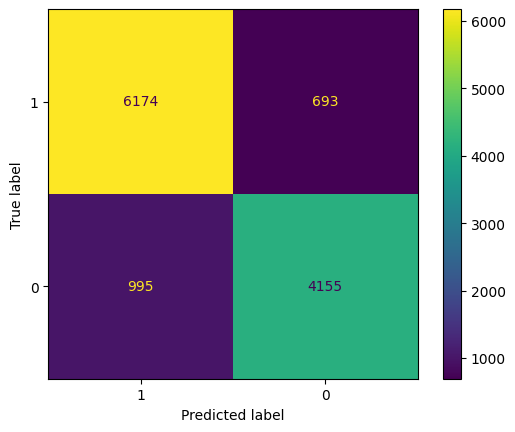

In [24]:
display_conf_matrix(Y_test, Y_pred_logreg, Y)

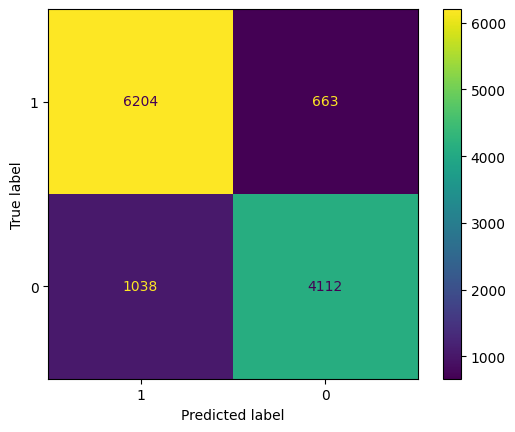

In [23]:
display_conf_matrix(Y_test, Y_pred_linSVC, Y)